In [ ]:
import tensorflow as tf

# Check for GPU availability
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"GPUs available: {[gpu.name for gpu in gpus]}")
else:
    print("No GPUs found. Please enable GPU in the Runtime settings.")


GPUs available: ['/physical_device:GPU:0']


In [ ]:
# Import necessary libraries
import os
import numpy as np
import shutil
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

In [ ]:
# Define the dataset path and parameters
DATASET_PATH = '/Users/rajat74/Downloads/big_data Food-101/food-101/images'
IMAGE_SIZE = (128, 128)  # Reduced image size for faster computation
BATCH_SIZE = 64
CLASSES = [
    'apple_pie', 'baby_back_ribs', 'beef_carpaccio', 'beef_tartare',
    'beet_salad', 'beignets', 'bibimbap', 'bread_pudding', 'breakfast_burrito',
    'bruschetta', 'caesar_salad', 'cannoli', 'caprese_salad', 'carrot_cake',
    'ceviche', 'cheesecake', 'chocolate_cake', 'chocolate_mousse', 'churros',
    'clam_chowder', 'club_sandwich', 'crab_cakes', 'creme_brulee', 'croque_madame',
    'cup_cakes'
]
# Create directories for the split datasets
train_dir = '/content/food-101/train'
val_dir = '/content/food-101/val'
test_dir = '/content/food-101/test'

# Function to create directories if they do not exist
def create_directory(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)

# Create train, validation, and test directories
create_directory(train_dir)
create_directory(val_dir)
create_directory(test_dir)

# Split dataset into train, validation, and test sets
for class_name in CLASSES:
    class_path = os.path.join(DATASET_PATH, class_name)
    images = os.listdir(class_path)
    np.random.shuffle(images)

    total_images = len(images)
    # Use fewer images per class for faster training
    #max_images = 100  # Limit to 100 images per class for this example
    #images = images[:max_images]
    subset_size = min(100, len(images))
    train_split = int(0.7 * len(images))
    val_split = int(0.1 * len(images))
    test_split = int(0.2 * len(images))

    train_images = images[:train_split]
    val_images = images[train_split:train_split + val_split]
    test_images = images[train_split + val_split:]

    for img in train_images:
        create_directory(os.path.join(train_dir, class_name))
        shutil.copy(os.path.join(class_path, img), os.path.join(train_dir, class_name, img))

    for img in val_images:
        create_directory(os.path.join(val_dir, class_name))
        shutil.copy(os.path.join(class_path, img), os.path.join(val_dir, class_name, img))

    for img in test_images:
        create_directory(os.path.join(test_dir, class_name))
        shutil.copy(os.path.join(class_path, img), os.path.join(test_dir, class_name, img))


In [ ]:
# Define ImageDataGenerators for train, validation, and test datasets
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
# Training data generator
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=CLASSES
)

# Validation data generator
val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=CLASSES
)

# Test data generator
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=CLASSES,
    shuffle=False
)

Found 24338 images belonging to 25 classes.
Found 6779 images belonging to 25 classes.
Found 12145 images belonging to 25 classes.


In [ ]:
# Building the hand-made CNN model
model = Sequential([
    Conv2D(32, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(0.001), input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
    MaxPooling2D(pool_size=(2, 2)),
    BatchNormalization(),
    Conv2D(64, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(0.001)),
    MaxPooling2D(pool_size=(2, 2)),
    BatchNormalization(),
    Conv2D(128, (5, 5), padding='same', activation='relu', kernel_regularizer=l2(0.001)),
    MaxPooling2D(pool_size=(2, 2)),
    BatchNormalization(),
    Conv2D(256, (7, 7), padding='same', activation='relu', kernel_regularizer=l2(0.001)),
    MaxPooling2D(pool_size=(2, 2)),
    BatchNormalization(),
    Flatten(),
    Dense(256, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.5),
    Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.5),
    Dense(len(CLASSES), activation='softmax')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0005), loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()

# Use early stopping to prevent overfitting
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_11 (Conv2D)          (None, 128, 128, 32)      896       
                                                                 
 max_pooling2d_11 (MaxPooli  (None, 64, 64, 32)        0         
 ng2D)                                                           
                                                                 
 batch_normalization_11 (Ba  (None, 64, 64, 32)        128       
 tchNormalization)                                               
                                                                 
 conv2d_12 (Conv2D)          (None, 64, 64, 64)        18496     
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 32, 32, 64)        0         
 ng2D)                                                           
                                                      

Epoch 1/30
381/381 [==============================] - 77s 192ms/step - loss: 4.2982 - accuracy: 0.0497 - val_loss: 4.0827 - val_accuracy: 0.0392
Epoch 2/30
381/381 [==============================] - 71s 187ms/step - loss: 3.9543 - accuracy: 0.0422 - val_loss: 3.8011 - val_accuracy: 0.0630
Epoch 3/30
381/381 [==============================] - 69s 180ms/step - loss: 3.7201 - accuracy: 0.0474 - val_loss: 3.6178 - val_accuracy: 0.0503
Epoch 4/30
381/381 [==============================] - 68s 180ms/step - loss: 3.5402 - accuracy: 0.0486 - val_loss: 3.4429 - val_accuracy: 0.0723
Epoch 5/30
381/381 [==============================] - 69s 182ms/step - loss: 3.4218 - accuracy: 0.0506 - val_loss: 3.3658 - val_accuracy: 0.0617
Epoch 6/30
381/381 [==============================] - 70s 184ms/step - loss: 3.3553 - accuracy: 0.0556 - val_loss: 3.2958 - val_accuracy: 0.0658
Epoch 7/30
381/381 [==============================] - 77s 203ms/step - loss: 3.3160 - accuracy: 0.0583 - val_loss: 3.3242 - val_ac

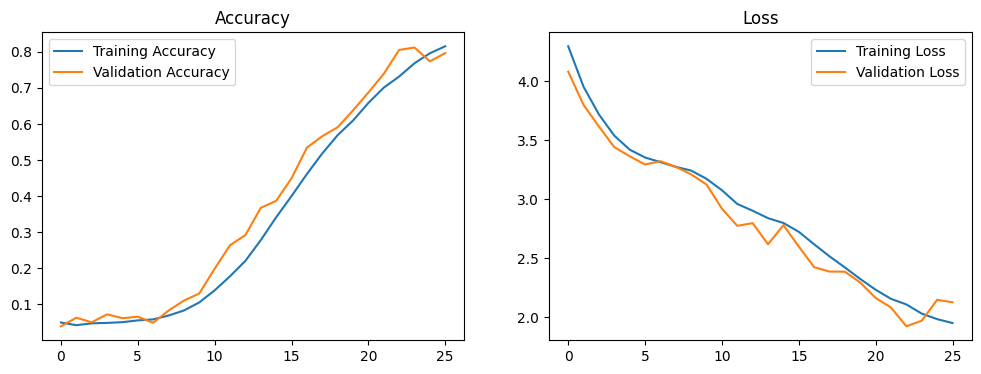

190/190 [==============================] - 26s 135ms/step


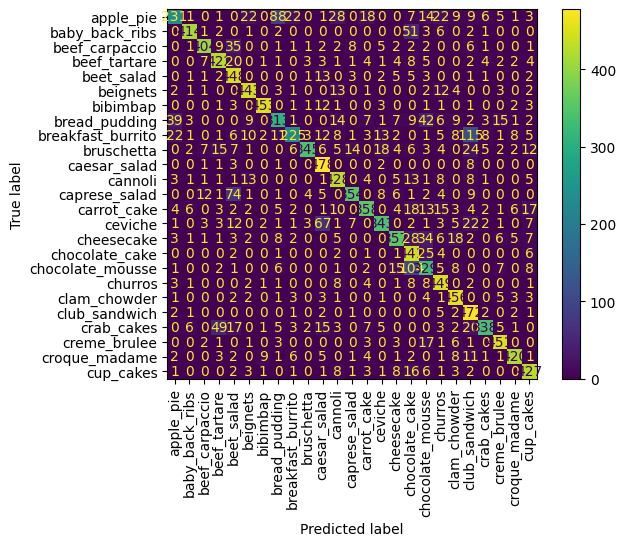

                   precision    recall  f1-score   support

        apple_pie       0.73      0.47      0.58       488
   baby_back_ribs       0.94      0.86      0.90       483
   beef_carpaccio       0.92      0.84      0.87       483
     beef_tartare       0.81      0.85      0.83       495
       beet_salad       0.70      0.92      0.79       488
         beignets       0.87      0.91      0.89       488
         bibimbap       0.96      0.94      0.95       483
    bread_pudding       0.69      0.65      0.67       483
breakfast_burrito       0.82      0.48      0.60       471
       bruschetta       0.95      0.71      0.81       488
     caesar_salad       0.76      0.97      0.85       494
          cannoli       0.79      0.87      0.83       494
    caprese_salad       0.91      0.73      0.81       482
      carrot_cake       0.85      0.75      0.80       476
          ceviche       0.85      0.70      0.77       487
       cheesecake       0.84      0.73      0.78       

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# Train the model
history = model.fit(
    train_generator,
    epochs=30,
    validation_data=val_generator,
    callbacks=[early_stopping]
)

# Evaluate the Model on test data
test_loss, test_accuracy = model.evaluate(test_generator)
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')

# Evaluate the Model
# Plot training and validation accuracy and loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')
plt.show()

# Confusion matrix
val_preds = model.predict(test_generator)
val_preds_classes = np.argmax(val_preds, axis=1)
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

cm = confusion_matrix(true_classes, val_preds_classes)
cmd = ConfusionMatrixDisplay(cm, display_labels=class_labels)
cmd.plot()
plt.xticks(rotation=90)
plt.show()

# Classification report
print(classification_report(true_classes, val_preds_classes, target_names=class_labels))

# Save the model
model.save('food101_cnn_model.h5')


In [ ]:
from google.colab import files
uploaded = files.upload()



Saving download (3).jpeg to download (3).jpeg


In [ ]:
import os

# Assuming the uploaded file is named '1272987.jpg'
image_path = list(uploaded.keys())[0]
print(f"Uploaded image path: {image_path}")

# Verify the file exists
if os.path.exists(image_path):
    print("The image file exists.")
else:
    print("The image file does not exist.")


Uploaded image path: download (3).jpeg
The image file exists.


In [ ]:
from tensorflow.keras.preprocessing import image
import numpy as np
import tensorflow as tf

# Function to predict the class of a given image
def predict_image_class(image_path, model, class_names):
    if os.path.exists(image_path):
        print(f"Image file found at {image_path}")
        # Load and preprocess the image
        img = image.load_img(image_path, target_size=(128, 128))
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array /= 255.0  # Normalize to [0, 1]

        # Make a prediction
        predictions = model.predict(img_array)
        predicted_class = np.argmax(predictions, axis=1)

        # Get the class label
        predicted_label = class_names[predicted_class[0]]
        return predicted_label
    else:
        print(f"Error: The file at {image_path} was not found.")
        return None

# Example usage
model_path = 'food101_cnn_model.h5'  # Path to your saved model
class_names = [
    'apple_pie', 'baby_back_ribs', 'beef_carpaccio', 'beef_tartare', 'beet_salad', 'beignets', 'bibimbap',
    'bread_pudding', 'breakfast_burrito', 'bruschetta', 'caesar_salad', 'cannoli', 'caprese_salad', 'carrot_cake',
    'ceviche', 'cheesecake', 'chocolate_cake', 'chocolate_mousse', 'churros', 'clam_chowder', 'club_sandwich',
    'crab_cakes', 'creme_brulee', 'croque_madame', 'cup_cakes'
]

# Load the model
model = tf.keras.models.load_model(model_path)

# Predict the class
predicted_label = predict_image_class(image_path, model, class_names)
if predicted_label:
    print(f"Predicted class: {predicted_label}")


Image file found at download (3).jpeg
1/1 [==============================] - 0s 114ms/step
Predicted class: carrot_cake
